Business problem:Peer-to-peer lending platforms rely on accurate credit risk assessment to maintain market reliability and investor trust. Misjudging borrower risk leads to capital loss and systemic distrust. FinSecure seeks to deploy an automated risk scoring engine capable of learning complex borrower behavior patterns from historical loan data.

 OBJECTIVE :This project designs and implements a complete ML pipeline that predicts loan repayment probability based on applicant characteristics and loan attributes. The model is optimized for ROC-AUC performance to ensure clear discrimination between safe and risky borrowers. Further, subgroup fairness analysis is performed to detect potential disparities in prediction quality across different loan purposes. This ensures that the resulting credit risk system is not only highly accurate but also equitable and audit-ready for real-world financial deployment.


Our first aim here was to understand default, in simple words it can be put as loans that were huge and were not paid back to the bank causing losses .
We have successfully installed all the libraries and loaded the datsets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/loan_data.csv")
df.head()



,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


We have the libraries and dataset now , understanding the data is very important here for understanding which fetaures are important for the model predictions . here , we will be counting : 
loans_paid_back :1
loans that were not paid back:0

In [2]:
df.info()
df.describe()
df["loan_paid_back"].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 26.6+ MB


loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64

Plotting to extarct the insights about the paid back and not paid

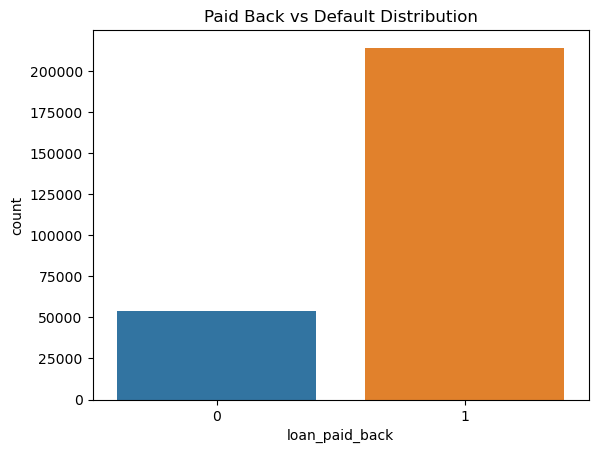

In [3]:
sns.countplot(x=df["loan_paid_back"])
plt.title("Paid Back vs Default Distribution")
plt.show()


In [4]:
#identifying columns
target = "loan_paid_back"
id_col = "id"
X = df.drop(columns=[target, id_col])
y = df[target]


In [5]:
#split data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Preprocessing


In [6]:
#NUMERICAL FEATURES

num_features = [
    "annual_income", "debt_to_income_ratio",
    "credit_score", "loan_amount", "interest_rate"
]


In [10]:
#CATEGORICAL FEATURES
cat_features = [
    "gender", "marital_status", "education_level",
    "employment_status", "loan_purpose", "grade_subgrade"
]



In [15]:
# CREATINNG TRANSFORMATIONS
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)



## modeling 
** We are using logistic regression as baseline model because simple, interpretable benchmark to compare more complex models against.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf_lr = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

clf_lr.fit(X_train, y_train)

y_pred_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print("gradient boost AUC: ",auc_lr)


gradient boost AUC:  0.9118756425428545


In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(loss="log_loss", random_state=42))
])

gb_clf.fit(X_train, y_train)

y_pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)
print("gradient boost AUC: ",auc_gb)


gradient boost AUC:  0.9184587357397639


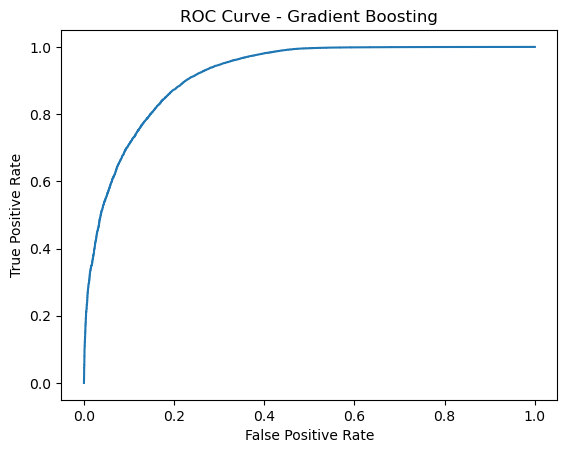

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_gb)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.show()


## Subgroup Fairness Analysis (Education+ Loan purpose)

In [19]:
X_test_copy = X_test.copy()
X_test_copy["loan_paid_back"] = y_test
X_test_copy["pred_prob"] = y_pred_proba_gb


In [20]:
edu_auc = {}
for level in X_test_copy["education_level"].unique():
    subset = X_test_copy[X_test_copy["education_level"] == level]
    if subset["loan_paid_back"].nunique() == 2:
        auc = roc_auc_score(subset["loan_paid_back"], subset["pred_prob"])
        edu_auc[level] = auc

edu_auc


{"Bachelor's": 0.9196892958171428,
 "Master's": 0.9156019015085121,
 'High School': 0.9160949249286219,
 'PhD': 0.9140606543822348,
 'Other': 0.9302541008947407}

## loan -pupose performnce ranking:

In [21]:
purpose_auc = {}
for purpose in X_test_copy["loan_purpose"].unique():
    subset = X_test_copy[X_test_copy["loan_purpose"] == purpose]
    if subset["loan_paid_back"].nunique() == 2:
        auc = roc_auc_score(subset["loan_paid_back"], subset["pred_prob"])
        purpose_auc[purpose] = auc

sorted(purpose_auc.items(), key=lambda x: x[1], reverse=True)[:3], \
sorted(purpose_auc.items(), key=lambda x: x[1])[:3]


([('Education', 0.9297894232595317),
  ('Vacation', 0.9256249999999999),
  ('Medical', 0.9250058884997925)],
 [('Car', 0.9087701185868796),
  ('Debt consolidation', 0.9174146278764621),
  ('Home', 0.9195528859596045)])

 This gave the top 3 performing purposes that are education, vacation,and medical 
 and the bottom 3: Car, Debt consolidation, home

## The model generalizes well overall and shows no severe fairness violations, but certain loan purpose groups, especially Car loans may require closer monitoring to ensure equitable credit decisioning in real-world deployment.